## Import Statementes

In [1]:
# Local application imports
import sys
# import src.utils
sys.path.append('../')
# import importlib
# importlib.reload(src.utils)

# Standard library imports
from src.utils import SaveModelMetrics

# Third-party imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import Levenshtein as lev

# Other settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


## Read in Small Group Dataset


These are the fields from the datasets that we want

- Census Data
  - census_carrier_name
  - plan_admin_name
- Ideon Data
  - id
  - carrier_name
  - name
  - plan_type
  - level
  - primary_care_physician
  - network_name
  - coinsurance
  - issuer_plan_code
  - hsa_eligible
  - individual_medical_deductible
- Evaluation Class
  - is_match


In [2]:
small_group_df_raw = pd.read_csv(
    '~/match-plans/data/small_group_dataset.csv', index_col=False)

full_df = small_group_df_raw[['id', 'census_carrier_name', 'plan_admin_name', 'carrier_name', 'name', 'plan_type', 'level',
                          'primary_care_physician', 'network_name', 'coinsurance', 'issuer_plan_code', 'hsa_eligible', 'individual_medical_deductible', 'is_match']].copy()


/var/folders/y2/_vfcy9tn1dx3_jnz4rgv92xh0000gn/T/ipykernel_42377/2473599286.py:1: DtypeWarning: Columns (13,26,65) have mixed types. Specify dtype option on import or set low_memory=False.
  small_group_df_raw = pd.read_csv(


## Naive Model


- This model is meant to be extremely simple; take the information from the census and take the information from ideon that defines carriers and plan name, and jam it together in a text embedding
- Let us see how far we can get without any sort of feature engineering at all
- We aren't going to do much hyperparameter tuning on this model, just a few folds and a few parameters


In [ ]:
# naive df
naive_df = full_df[['census_carrier_name', 'carrier_name',
                    'plan_admin_name', 'name', 'is_match']]


In [ ]:
# Combine the text columns into a single string
naive_df['text'] = naive_df['census_carrier_name'] + ' ' + naive_df['carrier_name'] + \
    ' ' + naive_df['plan_admin_name'] + ' ' + naive_df['name']

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=500)

# Fitting the model and transforming the data
X = vectorizer.fit_transform(naive_df['text']).toarray()
y = naive_df['is_match']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
}

# Create GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
)

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters
print('Best parameters found: ', grid.best_params_)
print('All parameters: ', grid.best_estimator_.get_params())

# Use the best model to make predictions
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
SaveModelMetrics(file_path='~/match-plans/data/model_results.csv').save_metrics(
    name='naive_model',
    description='A naive model that only concantenates the census information and matching ideon information to try and predict is_match using text embeddings',
    algorithm='XGBoostClassifier',
    best_params_grid_search=grid.best_params_,
    params=grid.best_estimator_.get_params(),
    accuracy_score=accuracy,
    precision_score=precision,
    recall=recall,
    f1_score=f1,
    conf_matrix=conf_matrix
)


## Plan Level & Carrier


- this model will take the niave model, but aim to make it better by feature engineering

1. Data Cleaning:
    * perform a bunch of data cleaning on the plan_admin_name and census_carrier_name to make comparison easier
2. Feature Engineering
    * cosine similarity between name and census_plan_admin_name_cleaned
    * length of each as a feature
    * census_carrier_name_cleaned and carrier_name cosine similarity
    * length of each as a feature
    * extract plan_type where available in plan_admin_name_cleaned

In [3]:
# Data Cleaning
df = full_df[['id','census_carrier_name','plan_admin_name','carrier_name','name','plan_type','level','hsa_eligible','is_match']].copy()
df.rename(columns={'plan_admin_name':'census_plan_admin_name','carrier_name':'ideon_carrier_name','name':'ideon_name','plan_type':'ideon_plan_type','level':'ideon_plan_level','hsa_eligible':'ideon_hsa_hdhp'},inplace=True)

# set up the cleaned column for plan_admin_name and census_carrier_name
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name']

# Remove any capital letter followed by ')' or ':' at the beginning of the string followed by any whitespace - ex: A) or A: or B)
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('^([A-Z]\\))\\s*|^([A-Z]\\:)\\s*', '', regex=True)

# in a similar way that we want to remove A) or anything, lets also remove numbers 1. or 2.
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\b\d{1,2}\.\s', 
    '', 
    regex=True
)

# lets remove anything contained in () or [] that is not an issuer_code. In other words, if it does not match [XXXX] or (XXXX), then lets remove the [] or if left
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\(([^)]*)\)|\[([^\]]*)\]|“([^”]*)”|\"([^\"]*)\"', 
    lambda x: x.group(0) if re.search(
        r'\([A-Z0-9]{2}-[A-Z0-9]{2}\)|\[A-Z0-9]{2}-[A-Z0-9]{2}\]|\([A-Z0-9]{4}\)|\[A-Z0-9]{4}\]|“[A-Z0-9]{2}-[A-Z0-9]{2}”|"[A-Z0-9]{2}-[A-Z0-9]{2}"|“[A-Z0-9]{4}”|"[A-Z0-9]{4}"', 
        x.group(0)
    ) 
    else '', 
    regex=True
)

# remove any weird characters after cleaning up a bunch - :, (, ), *, !, ", '
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('[!*“”":()]+', '', regex=True)

# remove any occurrence of '(BASE)', '(Base)', or '(base)', as well as any standalone 'BASE', 'Base', or 'base'
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('\\(BASE\\)|\\(Base\\)|\\(base\\)|\\bBASE\\b|\\bBase\\b|\\bbase\\b', '', regex=True).str.strip()

# remove the YYYY or YY-YY at the beginning of the string with a whitespace after, but be careful of XX-XX and XXXX and other numbers as those are valuable
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'^(?:\d{4}|\d{2}-\d{2}|\d{2})\s+', 
    '', 
    regex=True
)

# remove a plan_id if it is somehow in the string
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(r'\s*-\s*[0-9A-Z]{14,17}', '', regex=True)

# cleaning the census carrier name
df['census_carrier_name_cleaned'] = df['census_carrier_name']

df['census_carrier_name_cleaned'] = df['census_carrier_name_cleaned'].str.lower().replace({
    '.*anthem.*': 'Anthem',
    '.*choice.*': 'CalChoice',
    '.*medi.*': 'Medi-Excel',
    '.*cigna.*': 'Cigna + Oscar',
    '.*kaiser.*': 'Kaiser Permanente',
    '.*shield.*': 'BlueShield of California',
    '.*sutter.*': 'Sutter Health Plus',
    '.*covered.*': 'CoveredCA',
    '.*united.*': 'UnitedHealthcare',
    '.*uhc.*': 'UnitedHealthcare',
    '.*Western.*': 'Western Health Advantage',
    '.*sharp.*': 'Sharp Health Plan',
    '.*aetna.*': 'Aetna',
    '.*net.*': 'Health Net',
    '.*chinese.*': 'Chinese Community Health Plan'
}, regex=True)

# drop the old columns
df.drop(labels=['census_plan_admin_name','census_carrier_name'],axis=1,inplace=True)

### Feature Engineering


#### Carrier Name

In [4]:
# 1. Calculate length of 'census_carrier_name_cleaned' and 'carrier_name'
df['census_carrier_name_length'] = df['census_carrier_name_cleaned'].apply(len)
df['ideon_carrier_name_length'] = df['ideon_carrier_name'].apply(len)

# 2. Create text embeddings for 'census_carrier_name_cleaned' and 'carrier_name'
unique_census_carrier_names = pd.Series(df['census_carrier_name_cleaned'].unique()).dropna()
unique_ideon_carrier_names = pd.Series(df['ideon_carrier_name'].unique()).dropna()
all_unique_carrier_names = pd.concat([unique_census_carrier_names, unique_ideon_carrier_names]).unique()

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_unique_carrier_names)

# Transform 'census_carrier_name_cleaned' and 'ideon_carrier_name' to embeddings
df['census_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']).toarray())
df['ideon_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['ideon_carrier_name']).toarray())

# 3. Calculate cosine similarity between 'census_carrier_name_cleaned' and 'carrier_name' text embeddings
cosine_similarities = cosine_similarity(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']), tfidf_vectorizer.transform(df['ideon_carrier_name']))
df['carrier_name_cosine_similarity'] = [cosine_similarities[i][i] for i in range(len(df))]

#### Plan Level ['platinum','gold','silver','bronze']

In [34]:
# 1. Extract 'plan_level' from 'census_plan_admin_name_cleaned'
df['census_plan_level'] = df['census_plan_admin_name_cleaned'].str.extract('(gold|silver|platinum|bronze)', flags=re.IGNORECASE, expand=False)

# 2. Normalize 'plan_level'
df['census_plan_level'] = df['census_plan_level'].str.lower()
df['ideon_plan_level'] = df['ideon_plan_level'].replace('expanded_bronze', 'bronze')

# 3. Combine unique 'plan_level' values from both columns
unique_plan_levels_census = pd.Series(df['census_plan_level'].unique()).dropna()
unique_plan_levels_ideon = pd.Series(df['ideon_plan_level'].unique()).dropna()
all_unique_plan_levels = pd.concat([unique_plan_levels_census, unique_plan_levels_ideon]).unique()

# 4. Create text embeddings for unique 'plan_level' values
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_unique_plan_levels)

# 5. Transform 'census_plan_level' and 'ideon_plan_level' to embeddings
df['census_plan_level_embedding'] = list(tfidf_vectorizer.transform(df['census_plan_level'].fillna('')).toarray())
df['ideon_plan_level_embedding'] = list(tfidf_vectorizer.transform(df['ideon_plan_level'].fillna('')).toarray())

# 6. Calculate cosine similarity between 'census_plan_level_embedding' and 'ideon_plan_level_embedding'
df['plan_level_cosine_similarity'] = df.apply(lambda row: cosine_similarity([row['census_plan_level_embedding']], [row['ideon_plan_level_embedding']])[0][0], axis=1)


#### Plan Name ['ideon_name' and 'census_plan_admin_name_cleaned']

In [35]:
# 1. Calculate length of the name columns
df['census_plan_admin_name_cleaned_length'] = df['census_plan_admin_name_cleaned'].apply(len)
df['ideon_name_length'] = df['ideon_name'].apply(len)

# 2. create text embeddings for the name columns
df['plan_names_combined'] = df['census_plan_admin_name_cleaned'] + ' ' + df['ideon_name']
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_vectorizer.fit(df['plan_names_combined'])

# 3. Transform the plan name columns to embeddings
df['census_plan_admin_name_cleaned_embedding'] = list(tfidf_vectorizer.transform(df['census_plan_admin_name_cleaned'].fillna('')).toarray())
df['ideon_name_embedding'] = list(tfidf_vectorizer.transform(df['ideon_name'].fillna('')).toarray())

# 4. Calculate cosine similarity between 'census_plan_level_embedding' and 'ideon_plan_level_embedding'
df['plan_name_cosine_similarity'] = df.apply(lambda row: cosine_similarity([row['census_plan_admin_name_cleaned_embedding']], [row['ideon_name_embedding']])[0][0], axis=1)

In [ ]:
# Dat Preparation
X = df[[
    "census_carrier_name_length", 
    "ideon_carrier_name_length", 
    "carrier_name_cosine_similarity", 
    "census_plan_level",
    "ideon_plan_level",
    "plan_level_cosine_similarity", 
    "census_plan_admin_name_cleaned_length", 
    "ideon_name_length", 
    "plan_name_cosine_similarity"
]]
y = df["is_match"]

# split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]

# numerical columns
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Preprocessing for categorical data and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

# Define the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier()),
])

# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
}

# Create GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
)

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters
print('Best parameters found: ', grid.best_params_)

# Use the best model to make predictions
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
SaveModelMetrics(file_path='~/match-plans/data/model_results.csv').save_metrics(
    name='model_v1',
    description='A v1 model that cleans the carrier_name and plan_admin_name from the census to add in plan_level and carrier_name and then creates text embeddings and computes a similartity score.',
    algorithm='XGBoostClassifier',
    best_params_grid_search=grid.best_params_,
    params=grid.best_estimator_.get_params(),
    accuracy_score=accuracy,
    precision_score=precision,
    recall=recall,
    f1_score=f1,
    conf_matrix=conf_matrix
)

## Plan Type, HDHP / HSA, Levenshtein String Distance, Appendage

- this model will take the v1 model, and will add some more features around plan type and issuer code

1. Feature Engineering pt. 2
    * extract the plan type from the plan_admin_name string if available
    * convert the plan_type in the Ideon set to PPO, HMO, HDHP
    * add in HDHP / HSA from plan_admin_name and the boolean from Ideon dataset
2. I want to add in Levenshtein string distance just to see if that feature matters vs. the vector / text embeddings

In [36]:
# add the levenshtein string distance between plan_admin_name_cleaned and ideon_name
df['plan_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_plan_admin_name_cleaned'], row['ideon_name']), axis=1)
df['carrier_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_carrier_name_cleaned'], row['ideon_carrier_name']), axis=1)

# check if the census_plan_admin_name_cleaned has HSA or HDHP, with case set to false
df['census_hsa_hdhp'] = df['census_plan_admin_name_cleaned'].str.contains('HSA|HDHP', case=False)

# check for plan_type in the census_plan_admin_name_cleaned column, if it is in there, figure out which type (PPO or HMO), and then add that to the census_plan_type column
def determine_plan_type(name: str):
    lower_name = name.lower()
    if 'ppo' in lower_name or 'pos' in lower_name:
        return 'PPO'
    elif 'hmo' in lower_name:
        return 'HMO'
    else:
        return None

df['census_plan_type'] = df['census_plan_admin_name_cleaned'].apply(determine_plan_type)
    
# normalize ideon_plan_type column
df['ideon_plan_type'] = df['ideon_plan_type'].replace({'POS': 'PPO', 'EPO': 'PPO'})

# issuer code - if there is an issuer code in the census_plan_admin_name_cleaned, then lets extract that and add it to a column. then, lets do levenshtein string distance to that issuer_code and also cosine similarity


In [37]:
# Dat Preparation
X = df[[
    "census_carrier_name_length", 
    "ideon_carrier_name_length", 
    "carrier_name_cosine_similarity",
    "census_hsa_hdhp",
    "ideon_hsa_hdhp",
    "census_plan_type",
    "ideon_plan_type",
    "ideon_plan_level",
    "census_plan_level",
    "plan_level_cosine_similarity", 
    "census_plan_admin_name_cleaned_length", 
    "ideon_name_length", 
    "plan_name_cosine_similarity",
    "plan_name_levenshtein_distance",
    "carrier_name_levenshtein_distance"
]]
y = df["is_match"]

# split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]

# numerical columns
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Preprocessing for categorical data and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

# Define the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier()),
])

# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
}

# Create GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
)

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters
print('Best parameters found: ', grid.best_params_)

# Use the best model to make predictions
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
SaveModelMetrics(file_path='~/match-plans/data/model_results.csv').save_metrics(
    name='model_v2.4',
    description='A v2 model that uses the v1 model and adds on levenshtein distance between plan names and carrier names, adds in HDHP/HSA, and plan_type. Removed expanded bronze from the ideon set (replace with bronze)',
    algorithm='XGBoostClassifier',
    best_params_grid_search=grid.best_params_,
    params=grid.best_estimator_.get_params(),
    accuracy_score=accuracy,
    precision_score=precision,
    recall=recall,
    f1_score=f1,
    conf_matrix=conf_matrix
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'model__learning_rate': 0.2, 'model__max_depth': 9, 'model__n_estimators': 100}
Accuracy: 0.9986235375086029
Precision: 0.8809523809523809
Recall: 0.8409090909090909
F1 Score: 0.8604651162790699
Confusion Matrix:
[[8669    5]
 [   7   37]]


In [38]:
# Create a DataFrame with the true labels, predicted labels, and the test data
results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
})

In [39]:
results[results['y_true'] != results['y_pred']]

,y_true,y_pred
32215,0,1
1755,1,0
13415,0,1
39183,0,1
36593,1,0
6508,1,0
4732,0,1
13564,1,0
27411,0,1
13563,1,0


In [43]:
df.iloc[6508:6509]

,id,ideon_carrier_name,ideon_name,ideon_plan_type,ideon_plan_level,ideon_hsa_hdhp,is_match,census_plan_admin_name_cleaned,census_carrier_name_cleaned,census_carrier_name_length,ideon_carrier_name_length,census_carrier_name_text_embedding,ideon_carrier_name_text_embedding,carrier_name_cosine_similarity,census_plan_level,census_plan_level_embedding,ideon_plan_level_embedding,plan_level_cosine_similarity,census_plan_admin_name_cleaned_length,ideon_name_length,plan_names_combined,census_plan_admin_name_cleaned_embedding,ideon_name_embedding,plan_name_cosine_similarity,plan_name_levenshtein_distance,carrier_name_levenshtein_distance,census_hsa_hdhp,census_plan_type
6508,70285CA8160453,BlueShield of California,Gold Tandem PPO 0/25 OffEx,PPO,gold,False,1,Gold Tandom Narrow PPO 0/25,BlueShield of California,24,24,"[0.0, 0.0, 0.0, 0.5773502691896257, 0.0, 0.5773502691896257, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896257, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.5773502691896257, 0.0, 0.5773502691896257, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896257, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,gold,"[0.0, 1.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]",1.0,27,26,Gold Tandom Narrow PPO 0/25 Gold Tandem PPO 0/25 OffEx,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3670542287809456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5451218815330063, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0.307096,14,0,False,PPO


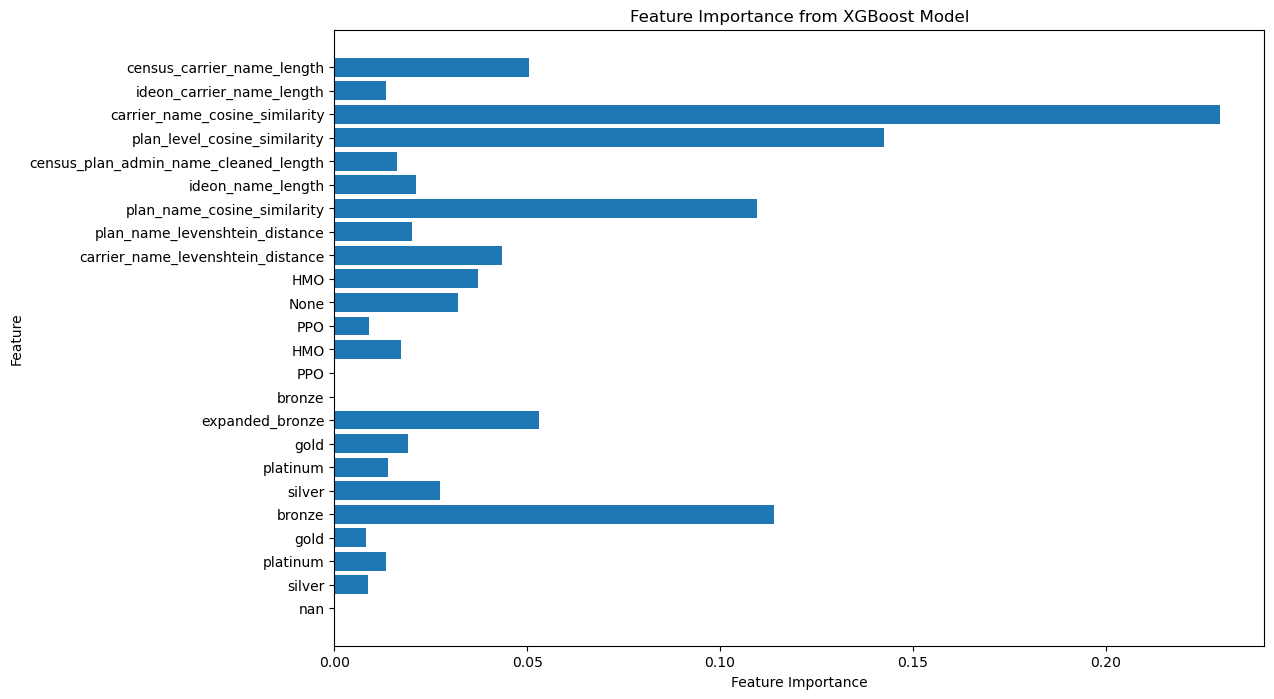

In [26]:
import matplotlib.pyplot as plt

# Get the best estimator from the grid search
best_model = grid.best_estimator_

# Get the feature importances from the fitted model
feature_importances = best_model.named_steps['model'].feature_importances_

# Get the feature names after preprocessing
# For numerical features, it's straightforward
feature_names = numerical_cols

# For categorical features, we need to transform the names to match the one-hot encoding
ohe_categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].categories_

# Flatten the list of categories per categorical feature
flat_categories = [item for sublist in ohe_categories for item in sublist]

# Combine numerical and categorical feature names
all_feature_names = feature_names + flat_categories

# Now we can plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(all_feature_names)), feature_importances, align='center')
plt.yticks(range(len(all_feature_names)), all_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# NOTES

* I'd love to find a way to handle the classification of Grandfathered / Non CA plans... isn't that a thing I can teach the model to handle?
* In other words, it would be no match for what that plan looks like and the reason would be Grandfathered? I feel like that is something I can program a model to understand, espeically one like XGBoost